# VIPERS SHAM Project
This notebook is part of the VIPERS-SHAM project:
http://arxiv.org/abs/xxxxxxx

Copyright 2019 by Ben Granett, granett@gmail.com
All rights reserved.
This file is released under the "MIT License Agreement". Please see the LICENSE
file that should have been included as part of this package.

In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
plt.style.use("small.style")
from matplotlib.ticker import FormatStrFormatter,ScalarFormatter
from matplotlib import colors,cm,ticker,transforms
import matplotlib.patches as patches

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import logging
logging.basicConfig(level=logging.INFO)

from scipy import interpolate, integrate

import numpy as np

import load
import emulator


In [2]:
labels = {
    'L1': '$0.5<z<0.7$',
    'L2': '$0.6<z<0.8$',
    'L3': '$0.7<z<0.9$',
    'L4': '$0.8<z<1.0$',
}

limits = {
    'L1':(-19.3, 9.26),
    'L2':(-19.8, 9.57),
    'L3':(-20.3, 9.93),
    'L4':(-20.8, 10.29),
 }

samples = ['sdss','L1','L2','L3','L4']

redshifts = {'sdss':.06, 'L1':0.6, 'L2':0.7, 'L3':0.8, 'L4':0.9}
n_components = 4
rmin = 0


In [3]:
r_sdss,wp_sdss,cov_sdss = load.load_sdss()
sel = r_sdss > rmin
r_sdss = r_sdss[sel]
wp_sdss = wp_sdss[sel]
cov_sdss = cov_sdss[sel,:][:,sel]

data = [(r_sdss, wp_sdss,None, cov_sdss)]

for sample in samples[1:]:
    r,wp = np.loadtxt('../data/vipers/wp_sM{sample}.txt'.format(sample=sample[1]), unpack=True)
    r2,wp2 = np.loadtxt('../data/vipers/wp_s{sample}.txt'.format(sample=sample), unpack=True)
    cmat = np.loadtxt('../data/vipers/cov_{sample}.txt'.format(sample=sample))
    sel = r > rmin
    r = r[sel]
    wp = wp[sel]
    wp2 = wp2[sel]
    cmat = cmat[sel,:][:,sel]
    data.append((r,wp,wp2,cmat))

In [4]:
shamdata = {}
for sample in ['sdss','L1','L2','L3','L4']:
    sham = load.load_sham(sample=sample, template="../data/sham400/nz_{sample}/wp_snap{snapshot:7.5f}.txt")
    snapshots = sham.keys()
    snapshots.sort()
    for key in snapshots:
        r, wp = sham[key]
        sel = r > rmin
        r = r[sel]
        wp = wp[sel]
        if not sample in shamdata:
            shamdata[sample] = []
        shamdata[sample].append((key, r, wp))

a_samples = []
interpolators = []
for key in samples:
    y = []
    x = []
    for a,r,w in shamdata[key]:
        sel = r > rmin
        r = r[sel]
        y.append(w[sel])
        x.append(a)
    y = np.array(y)
    x = np.array(x)
    f = emulator.WpInterpolator(x, r, y, n_components)
    interpolators.append(f)
    a_samples.append(1./(1+redshifts[key]))
a_samples = np.array(a_samples)

INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.53000.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.62230.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.66430.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.71240.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.77240.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.83240.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.90740.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap1.00000.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.44200.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.50000.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.53000.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.55630.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.58640.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.62230.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.66430.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.71240.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.77240.tx

0 sdss 0.9433962264150942
1 L1 0.625
2 L2 0.5882352941176471
3 L3 0.5555555555555556
4 L4 0.5263157894736842


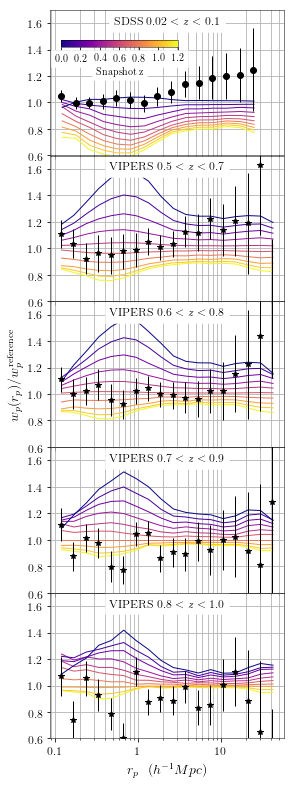

In [5]:
fig = plt.figure(figsize=(4,11))

ax = None
e = 0.8

zz = np.linspace(0,1.2,10)[::-1]
aa = 1./(1+zz)
sm = cm.ScalarMappable(colors.Normalize(zz.min(),zz.max()), 'plasma')
sm._A = []

axes = []


for i,sample in enumerate(samples):
    print i, sample, a_samples[i]
    ax = plt.subplot(5,1,i+1, sharex=ax, sharey=ax)
    axes.append(ax)

    f = interpolators[i]
    mod = f.r**e * f(a_samples[i])

    r,wp,wp2,cmat = data[i]
    sig = r**e * cmat.diagonal()**.5 / mod
    
    d = r**e * wp / mod
    
    if wp2 is not None:
        d2 = r**e * wp2 / mod
    
    if sample == 'sdss':
        ax.errorbar(r, d, yerr=sig, marker="o", ls='None', c='k', label="$M_r<-20$", zorder=20)
        ax.text(0.5,0.9,"SDSS $0.02 < z < 0.1$", transform=ax.transAxes, ha='center', fontsize=12,backgroundcolor='w',color='k', zorder=2)
        ax.tick_params(labelbottom=False)
    else:
        ax.errorbar(r, d, yerr=sig, marker="*", ls='None', c='k', label="$M_{\star}>%g$"%limits[sample][1], zorder=20)
        plt.text(0.5,0.9, "VIPERS "+labels[sample], transform=ax.transAxes, ha='center', fontsize=12,color='k',backgroundcolor='w',zorder=2)
    
    for a in aa:
        ax.plot(f.r, f.r**e * f(a)/mod, c=sm.to_rgba(1./a-1))
        
    
    if i < 4:
        ax.tick_params(labelbottom=False)
        
    if i == 4:
        plt.xlabel("$r_p\ \ (h^{-1}Mpc)$")
    ax.set_yscale('linear')
    ax.set_xscale('log')

    ax.grid(which='both',zorder=1)
    
    ax.set_ylim(0.6,1.7)

    ax.xaxis.set_major_formatter(FormatStrFormatter("%g"))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(25))

    if i==2:
        ax.set_ylabel("$w_p(r_p) / w_{p}^{\\rm reference}$")
        
        
cax = inset_axes(axes[0],
                width="25%",  # width = 50% of parent_bbox width
                height="5%",  # height : 5%
                bbox_to_anchor=transforms.Bbox.from_bounds(0.02,0.7,2,1),
                bbox_transform=axes[0].transAxes,
                loc=3,
)

cax.tick_params(labelsize=10)
                 
cb = plt.colorbar(sm, cax=cax, orientation='horizontal',)
cb.set_label( label='Snapshot z', fontsize=10, backgroundcolor="w")

plt.setp(cax.get_xticklabels(), backgroundcolor="w")


plt.subplots_adjust(wspace=0.001, hspace=.001)

plt.subplots_adjust(left=0.17,right=0.98,bottom=.06,top=0.98)
plt.savefig("../figs/fig7.pdf")


0 sdss 0.9433962264150942
1 L1 0.625
2 L2 0.5882352941176471
3 L3 0.5555555555555556
4 L4 0.5263157894736842


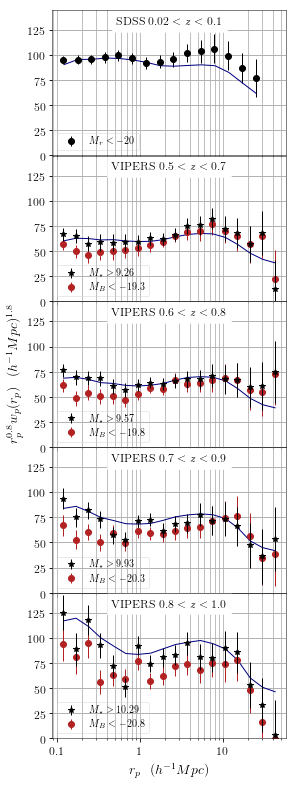

In [6]:
plt.figure(figsize=(4,11))

ax = None
e = 0.8

for i,sample in enumerate(samples):
    print i, sample, a_samples[i]
    ax = plt.subplot(5,1,i+1, sharex=ax, sharey=ax)

    f = interpolators[i]
    mod = f.r**e * f(a_samples[i])

    r,wp,wp2,cmat = data[i]
    sig = r**e * cmat.diagonal()**.5
    
    d = r**e * wp
    
    if wp2 is not None:
        d2 = r**e * wp2
    
    if sample == 'sdss':
        ax.errorbar(r, d, yerr=sig, marker="o", ls='None', c='k', label="$M_r<-20$")
        ax.text(0.5,0.9,"SDSS $0.02 < z < 0.1$", transform=ax.transAxes, ha='center', fontsize=12,backgroundcolor='w',color='k', zorder=2)
        ax.tick_params(labelbottom=False)
    else:
        ax.errorbar(r, d, yerr=sig, marker="*", ls='None', c='k', label="$M_{\star}>%g$"%limits[sample][1], zorder=20)
        ax.errorbar(r, d2, yerr=sig, marker="o", ls='None', c='firebrick', label="$M_B<%g$"%limits[sample][0])
        plt.text(0.5,0.9, "VIPERS "+labels[sample], transform=ax.transAxes, ha='center', fontsize=12,color='k',backgroundcolor='w',zorder=2)

    ax.plot(f.r, mod, c='navy')
    
    if i < 4:
        ax.tick_params(labelbottom=False)
        
    if i == 4:
        plt.xlabel("$r_p\ \ (h^{-1}Mpc)$")
    ax.legend(loc='lower left', fontsize=10)
    ax.set_yscale('linear')
    ax.set_xscale('log')

    ax.grid(which='both',zorder=1)
    
    ax.set_ylim(0,145)

    ax.xaxis.set_major_formatter(FormatStrFormatter("%g"))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(25))

    if i==2:
        ax.set_ylabel("$r_p^{0.8} w_p(r_p)\ \ (h^{-1}Mpc)^{1.8}$")

plt.subplots_adjust(wspace=0.001, hspace=.001)

plt.subplots_adjust(left=0.17,right=0.98,bottom=.06,top=0.98)
plt.savefig("../figs/fig4.pdf")
